# (Mini) projet - Analyse, classification et indexation des données

Premièrement, nous chargeons les données :

In [14]:
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

Exemple montrant une image du jeu de données :

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

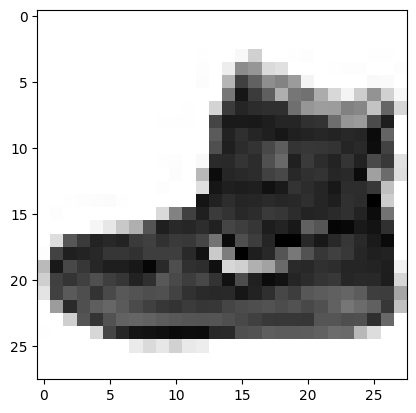

9


In [15]:
%matplotlib inline
plt.imshow(X_train[0], cmap=cm.Greys)
plt.show()
print(y_train[0])

## 1. Reemplacer les étiquettes

Maintenant, nous allons remplacer les labels pour n'avoir que deux classes : 0 pour les vêtements (lorsque la classe d'origine est différente de 8) et 1 dans le cas des accessoires (lorsque la classe d'origine est égale à 8). Nous avons choisi que les vêtements soient la classe négative et les accessoires la classe positif pusique cette dernière est la classe minoritaire (cette décision nous aidera plus tard, lorsque nous obtiendrons les métriques des modèles) :

In [16]:
def reemplacer_labels(y):
    return (y == 8).astype(int)

In [17]:
import numpy as np

In [18]:
y_train = reemplacer_labels(y_train)
y_test = reemplacer_labels(y_test)

In [68]:
nb_vetements = np.count_nonzero(y_train == 0)
nb_accesoires = np.count_nonzero(y_train == 1)
print('Number of vetements: ', nb_vetements)
print('Number of accesoires: ', nb_accesoires)

Number of vetements:  54000
Number of accesoires:  6000


## 2. Tests avec classifieurs

Nous allons entraîner le modèle avec les classifieurs k-nn, naïve Bayes, des arbres de décision et des forêts aléatoires. Tout d'abord, nous allons aplatir les données afin de pouvoir travailler avec sklearn :

In [8]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [71]:
print('Number of features: ', len(X_train_flat[0]))

Number of features:  784


Nous importerons également les modules liés aux métriques :

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### k-nn

In [30]:
from sklearn.neighbors import KNeighborsClassifier

Tout d'abord, nous allons essayer le knn avec les hyperparamètres par défaut (c'est-à-dire avec 5 voisins) :

In [15]:
knn = KNeighborsClassifier()

In [16]:
%timeit knn.fit(X_train_flat, y_train)

2.07 ms ± 71.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
y_pred = knn.predict(X_test_flat)

In [18]:
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

Confusion matrix:
 [[8979   21]
 [  50  950]]


In [19]:
print('Accuracy: ', '{:2.2%}'.format(accuracy_score(y_test, y_pred)))
print('Precision: ', '{:2.2%}'.format(precision_score(y_test, y_pred)))
print('Recall: ', '{:2.2%}'.format(recall_score(y_test, y_pred)))
print('F1 score: ', '{:2.2%}'.format(f1_score(y_test, y_pred)))

Accuracy:  99.29%
Precision:  97.84%
Recall:  95.00%
F1:  96.40%


Nous pouvons voir que l'accuracy est assez élevée, mais nous devons tenir compte du fait que les classes sont déséquilibrées (il y a un rapport entre vrais positifs et négatifs de 10:1), donc l'accuracy sera bonne même si la prédiction des negatifs est pas bon (c'est-à-dire que nous courons le risque que notre modèle mette plus d'éléments que nous le devrions dans la classe négative sans affecter l'accuracy).

Il est donc nécessaire de décider quelle métrique d'évaluation utiliser : précision, recall ou score F. Considérons que la précision est utilisée lorsque le coût d'avoir un faux positif est élevé (comme dans la détection de spam) et le recall, lorsque le coût d'avoir un faux négatif est élevé (comme dans le cas de la détection d'une maladie). Le score F1 est la moyenne harmonique des deux mesures précédentes, nous avons donc décidé d'utiliser cette dernière (puisque la mauvaise classification d'un accessoire n'est pas considérée comme plus importante que la mauvaise classification des vêtements, ou vice versa, mais nous voulons un équilibre entre les deux).

Maintenant, nous allons essayer de trouver un modèle plus optimal :

In [58]:
def search_knn_best_model(X_train, X_test, y_train, y_test, metric=accuracy_score, n=100, patience=5):
    best_metric = -1
    best_k = None
    best_model = None
    k = 1
    p = patience
    while k < n and p > 0:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        metric_value = metric(y_test, y_pred)
        print('k = ', k, ', Metric = {:2.2%}'.format(metric_value))
        if (metric_value > best_metric):
            best_metric = metric_value
            best_model = knn
            best_k = k
            p += 1
        p -= 1
        k += 1
    return best_model, best_k, best_metric

In [59]:
def knn_test():
    knn, k, f1_value = search_knn_best_model(X_train_flat, X_test_flat, y_train, y_test, f1_score)
    print('Best model: k = ', k, ', F1 score = {:2.2%}'.format(f1_value))

In [60]:
%timeit -r 1 -n 1 knn_test()

k =  1 , Metric = 97.01%
k =  2 , Metric = 95.78%
k =  3 , Metric = 96.55%
k =  4 , Metric = 96.42%
k =  5 , Metric = 96.40%
k =  6 , Metric = 96.06%
Best model: k =  1 , F1 score = 97.01%
1min 30s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Naïve Bayes

Dans ce cas, nous nous en tiendrons aux hyperparamètres par défaut (laissons la bibliothèque calculer les probabilités à priori en fonction des données).

In [49]:
from sklearn.naive_bayes import GaussianNB

In [50]:
nb = GaussianNB()
%timeit nb.fit(X_train_flat, y_train)

In [52]:
y_pred = nb.predict(X_test_flat)

In [53]:
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

Confusion matrix:
 [[8290  710]
 [ 238  762]]


In [56]:
print('F1 score: ', '{:2.2%}'.format(f1_score(y_test, y_pred)))

F1 score:  61.65%


### Arbres de décision

In [10]:
from sklearn import tree

Nous testons la classification avec les paramètres par défaut :

In [ ]:
dt = tree.DecisionTreeClassifier()
%timeit dt.fit(X_train_flat, y_train)

In [4]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
# import pydotplus
import numpy as np

In [ ]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_data(dot_data.getvalue())
Image(graph.create_png())

In [21]:
y_pred = dt.predict(X_test_flat)

In [22]:
print('F1 score: ', '{:2.2%}'.format(f1_score(y_test, y_pred)))

F1 score:  91.00%


Maintenant nous allons essayer de trouver de meilleurs paramètres pour notre modèle, nous utilisons donc RandomizedSearchCV :

In [4]:
from sklearn.model_selection import RandomizedSearchCV

In [14]:
criterion = ['gini', 'entropy']
max_depth = [3, 5, 10]
min_samples_leaf = [1, 2, 5]
min_samples_split = [2, 3, 4]

random_grid = {'max_depth': max_depth,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split}
print(random_grid)

{'max_depth': [3, 5, 10], 'min_samples_leaf': [1, 2, 5], 'min_samples_split': [2, 3, 4]}


In [15]:
dt = tree.DecisionTreeClassifier()
dt_random = RandomizedSearchCV(estimator=dt, param_distributions=random_grid, n_iter=9,
                               random_state=2, cv=3, verbose=2, n_jobs=-1)

In [16]:
dt_random.fit(X_train_flat, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
47.2 s ± 263 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
dt_random.best_params_

{'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 10}

[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.952 total time=   5.2s
[CV 3/3] END max_depth=5, min_samples_leaf=1, min_samples_split=2;, score=0.978 total time=   8.2s
[CV 2/3] END max_depth=5, min_samples_leaf=5, min_samples_split=3;, score=0.979 total time=   7.9s
[CV 3/3] END max_depth=3, min_samples_leaf=5, min_samples_split=2;, score=0.951 total time=   5.2s
[CV 2/3] END max_depth=10, min_samples_leaf=5, min_samples_split=3;, score=0.984 total time=  17.1s
[CV 1/3] END max_depth=5, min_samples_leaf=2, min_samples_split=2;, score=0.978 total time=   8.0s
[CV 2/3] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.949 total time=   4.7s
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.952 total time=   5.2s
[CV 2/3] END max_depth=10, min_samples_leaf=1, min_samples_split=4;, score=0.984 total time=  15.6s
[CV 1/3] END max_depth=3, min_samples_leaf=5, min_samples_split=2;, score=0.952 total time=   4.8s
[CV 3/3]

[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.951 total time=   5.2s
[CV 1/3] END max_depth=10, min_samples_leaf=1, min_samples_split=4;, score=0.983 total time=  15.9s
[CV 2/3] END max_depth=3, min_samples_leaf=5, min_samples_split=2;, score=0.949 total time=   4.9s
[CV 1/3] END max_depth=10, min_samples_leaf=5, min_samples_split=3;, score=0.983 total time=  17.1s
[CV 2/3] END max_depth=5, min_samples_leaf=2, min_samples_split=2;, score=0.979 total time=   8.2s
[CV 1/3] END max_depth=5, min_samples_leaf=5, min_samples_split=4;, score=0.978 total time=   6.3s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.951 total time=   5.2s
[CV 1/3] END max_depth=10, min_samples_leaf=1, min_samples_split=4;, score=0.983 total time=  16.3s
[CV 2/3] END max_depth=3, min_samples_leaf=5, min_samples_split=2;, score=0.949 total time=   5.2s
[CV 1/3] END max_depth=10, min_samples_leaf=5, min_samples_split=3;, score=0.983 total time=  16.3s
[CV 2/

In [19]:
best_dt = tree.DecisionTreeClassifier(max_depth=10,
                                 min_samples_split=4,
                                min_samples_leaf=1)
%timeit best_dt.fit(X_train_flat, y_train)

14.5 s ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
y_pred = best_dt.predict(X_test_flat)

In [22]:
print('F1 score: ', '{:2.2%}'.format(f1_score(y_test, y_pred)))

F1 score:  91.58%


### Forêts aléatoires

In [2]:
from sklearn.ensemble import RandomForestClassifier

Encore une fois, nous essayons d'abord les hyperparamètres par défaut :

In [24]:
rf = RandomForestClassifier()
%timeit rf.fit(X_train_flat, y_train)

1min 8s ± 304 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
y_pred = rf.predict(X_test_flat)

In [27]:
print('F1 score: ', '{:2.2%}'.format(f1_score(y_test, y_pred)))

F1 score:  96.81%


Maintenant, nous cherchons le meilleur modèle :

In [19]:
criterion = ['gini', 'entropy']
# n_estimators = [int(i) for i in np.linspace(200, 2000, num=10)]
# max_features = ['sqrt', None]
# max_depth = [int(i) for i in np.linspace(10, 110, num=11)]
# max_depth.append(None)
max_depth = [3, 5, 10]
min_samples_leaf = [1, 2, 5]
min_samples_split = [2, 5, 10]
# bootstrap = [True, False]

random_grid = {'criterion': criterion,
#                'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap
              }
print(random_grid)

{'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 10], 'min_samples_leaf': [1, 2, 5], 'min_samples_split': [2, 5, 10]}


In [20]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=5,
                               random_state=42, cv=3, verbose=2, n_jobs=-1)

In [21]:
rf_random.fit(X_train_flat, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, verbose=2)

In [22]:
rf_random.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'criterion': 'entropy'}

In [23]:
best_rf = RandomForestClassifier(min_samples_split=2,
                                min_samples_leaf=2,
                                max_depth=10,
                                criterion='entropy')
%timeit best_rf.fit(X_train_flat, y_train)

[CV] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=  40.3s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=  32.0s
34.7 s ± 149 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
y_pred = best_rf.predict(X_test_flat)

In [29]:
print('F1 score: ', '{:2.2%}'.format(f1_score(y_test, y_pred)))

F1 score:  96.19%


Notons que, bien que nous prenions un petit nombre de paramètres à faire varier pour l'entraînement de notre modèle, ce dernier prend un temps considérable. C'est pourquoi il est nécessaire de faire de la LDA.

## 3. Réduction de dimension avec le LDA

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [10]:
lda = LinearDiscriminantAnalysis()

In [23]:
X_train_p = lda.fit_transform(X_train_flat, y_train)
X_test_p = lda.transform(X_test_flat)

In [73]:
len(X_train_p[0])

1

Nous pouvons voir les données réduites :

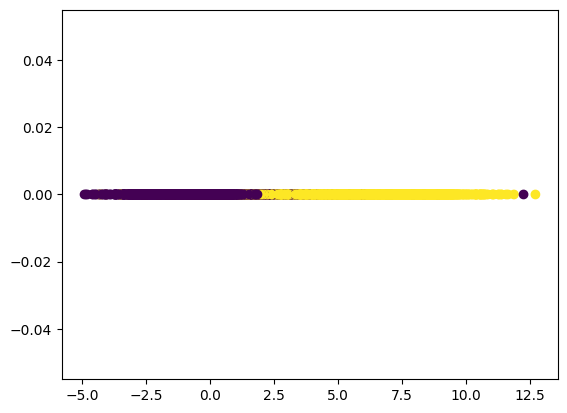

In [77]:
plt.scatter(X_train_p[:,0], np.zeros(X_train_p.shape[0]), c=y_train)
plt.show()

Notons que la séparation entre les classes semble assez bonne visuellement.

### knn

Dans un premier temps, nous testons l'impact de la réduction dans un modèle knn :

In [50]:
def knn_test():
    knn, k, f1_value = search_knn_best_model(X_train_p, X_test_p, y_train, y_test, f1_score)
    print('Best model: k = ', k, ', F1 score = {:2.2%}'.format(f1_value))

In [57]:
%timeit -r 1 -n 1 knn_test()

k =  1 , Metric = 87.02%
k =  2 , Metric = 87.42%
k =  3 , Metric = 90.10%
k =  4 , Metric = 89.68%
k =  5 , Metric = 90.01%
k =  6 , Metric = 89.78%
k =  7 , Metric = 90.33%
k =  8 , Metric = 90.71%
k =  9 , Metric = 90.67%
k =  10 , Metric = 90.61%
Best model: k =  8 , F1 score = 90.71%
1.98 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Nous pouvons voir que le temps est considérablement réduit par rapport au temps d'apprentissage du modèle sans réduction. Cela s'explique par le fait que, lorsque nous obtiendrons la distance de deux points dans le modèle avec réduction (n'ayant qu'un seul attribut), nos obtiendrons simplement une distance sur la droite numérique, alors que dans le cas précédent, nous devions obtenir la distance entre deux points dans un espace de dimension 784, qui a une complexité plus élevée (il faut ajouter 784 termes au carré et obtenir la racine dans chaque cas). On peut voir, en revanche, que la métrique est moins bonne (d'environ 7 points de pourcentage), mais ce n'est pas si significatif compte tenu du fait que la dimension a été réduite 784 fois.

### Forêts aléatoires